# Group 1
Fabio Ceruti - Fabio Martino - Alex Lucchini - Jacopo Biggiogera

This notebook contains the code that we used to carry out the color analysis for the suit of models developed in the other sections.

In [1]:
import os
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

## Preparing the data for the analysis
This section prepares the data for the analysis by loading it and creating train and validation data with balanced classes.

In [2]:
#Loading the data
paths_colors=pd.read_csv('train_val_data.csv')
paths_colors['label']=paths_colors['label'].astype('str')

,path,label
0,Animals/Junonia coenia/17e3341a4686186167bacb7...,4
1,Animals/Pachydiplax longipennis/6e93a9cace6545...,5


In [4]:
#Creating a balanced split between training and test
paths_colors=pd.read_csv('train_val_data.csv')
paths_colors['label']=paths_colors['label'].astype('str')
X_train, X_val, y_train, y_val = train_test_split(paths_colors['path'],paths_colors['label'], test_size=0.176, stratify=paths_colors['label'])
train_df = pd.DataFrame({'path':X_train, 'label':y_train}).reset_index(drop=True)
valid_df = pd.DataFrame({'path':X_val, 'label':y_val}).reset_index(drop=True)

## Black and White
This section fits a model for black and white predictions.

In [5]:
#Contructing the data generator for training and validation and moving the data to GPU
def togpu(img):
    with tf.device('/gpu:0'):
        tens_data = tf.constant(img)
    return tens_data
    
train_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu, #check that you can make multiple functions and pass them in a list
                                 rotation_range=90, brightness_range=[0.1, 2], shear_range=90, zoom_range=[1, 2])

val_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu)

batch_s = 20

train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='grayscale',
    target_size=(350,350),
    batch_size=batch_s
)

validation_generator=val_datagen.flow_from_dataframe(
   valid_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='grayscale',
    target_size=(350,350),
    batch_size=batch_s,
    shuffle=False
)

Found 11967 validated image filenames belonging to 12 classes.
Found 2557 validated image filenames belonging to 12 classes.


*Explanation for augmentations used*
- Rotation range: can be useful to consider various angles of a picture; We put a random rotation of max 90 degrees as it simulates possible distortions in images taken by individuals.
- Brightness range: can be useful to simulate too high exposure and dark environments. We insert a range including both darker and brighter images.
- Shear range: can be useful to simulate animals' motions. We use max 90 derees to simulate movements of animals.
- Zoom range: we zoom out of the picture, this ensures that the model can classify also when the animal has a relative smaller size in the photo. 

In [7]:
#Importing ResNet50 for transfer learning
base_model = ResNet50(weights='imagenet',input_shape=(350, 350, 3),include_top=False)  # original input shape for model (480,480,3)
base_model.trainable = True #freeze parameters of imported model

inputs = keras.Input(shape=(350, 350, 1))
x = keras.layers.Conv2D(3, (3, 3), padding = 'same')(inputs)
x = base_model(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu',name='last_conv')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(12, activation='softmax')(x) #predict the class
model = keras.Model(inputs, outputs) #put everything together
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 350, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 350, 350, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 last_conv (Conv2D)          (None, 9, 9, 64)          1179712   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                780       
                                                             

In [8]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']) 

In [9]:
earlystop=EarlyStopping(monitor='val_accuracy',
                        min_delta=0.01,
                        patience=3,
                        verbose=1,
                        mode='auto')
csv_logger=CSVLogger('training_gray.log',separator=",",append=False)

In [10]:
stepepoch = 11967/20
valsteps = 2557/20
history = model.fit(train_generator,
      epochs=10,
      steps_per_epoch = stepepoch,
      validation_data=validation_generator,
      validation_steps = valsteps,
      callbacks=[earlystop, csv_logger])

Epoch 1/10
598/598 [==============================] - 1008s 2s/step - loss: 2.4605 - accuracy: 0.1542 - val_loss: 2.2576 - val_accuracy: 0.1963
Epoch 2/10
598/598 [==============================] - 973s 2s/step - loss: 2.2461 - accuracy: 0.2095 - val_loss: 2.1394 - val_accuracy: 0.2468
Epoch 3/10
598/598 [==============================] - 974s 2s/step - loss: 2.1544 - accuracy: 0.2472 - val_loss: 2.0450 - val_accuracy: 0.2687
Epoch 4/10
598/598 [==============================] - 974s 2s/step - loss: 2.1036 - accuracy: 0.2630 - val_loss: 2.0100 - val_accuracy: 0.2847
Epoch 5/10
598/598 [==============================] - 974s 2s/step - loss: 2.0527 - accuracy: 0.2758 - val_loss: 1.9684 - val_accuracy: 0.3058
Epoch 6/10
598/598 [==============================] - 975s 2s/step - loss: 2.0337 - accuracy: 0.2915 - val_loss: 1.9132 - val_accuracy: 0.3375
Epoch 7/10
598/598 [==============================] - 975s 2s/step - loss: 1.9913 - accuracy: 0.3111 - val_loss: 1.8761 - val_accuracy: 0.350

In [11]:
#storing the predictions on validation data
prediction_classes = np.array([])
true_classes =  np.array([])
step = 0
for x, y in tqdm(validation_generator):
    prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x, verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
    step+=1
    if step == 133:
        break

132it [01:31,  1.44it/s]                         


In [13]:
valid_df['predicted_label_gray']=prediction_classes[:2557]
valid_df.to_csv('val_results/blackwhite_analysis_results.csv', index=False)

In [15]:
#Save the model
model.save('saved_models/model_grayscale')
model.save('saved_models/model_grayscale.h5')

INFO:tensorflow:Assets written to: saved_models/model_grayscale/assets


INFO:tensorflow:Assets written to: saved_models/model_grayscale/assets


## Only one channel at the time
This section provides an application of transfer learning to each single color channel separately.

In [5]:
#Defining a suit of functions to move the data to the GPU and selecting 1 color channel
def togpu_red(img):
    if len(img.shape)>2:
        im_r = np.zeros(np.shape(img))
        im_r[:, :, 0] = img[:, :, 0]
    else:
        im_shape = [i for i in img.shape]
        im_shape.append(3)
        im_r = np.zeros(im_shape)
        im_r[:, :, 0] = img[:, :, 0]
    with tf.device('/gpu:0'):
        tens_data = tf.constant(im_r)
    return tens_data

def togpu_green(img):
    if len(img.shape)>2:
        im_r = np.zeros(np.shape(img))
        im_r[:, :, 1] = img[:, :, 1]
    else:
        im_shape = [i for i in img.shape]
        im_shape.append(3)
        im_r = np.zeros(im_shape)
        im_r[:, :, 1] = img[:, :, 1]
    with tf.device('/gpu:0'):
        tens_data = tf.constant(im_r)
    return tens_data

def togpu_blue(img):
    if len(img.shape)>2:
        im_r = np.zeros(np.shape(img))
        im_r[:, :, 2] = img[:, :, 2]
    else:
        im_shape = [i for i in img.shape]
        im_shape.append(3)
        im_r = np.zeros(im_shape)
        im_r[:, :, 2] = img[:, :, 2]
    with tf.device('/gpu:0'):
        tens_data = tf.constant(im_r)
    return tens_data

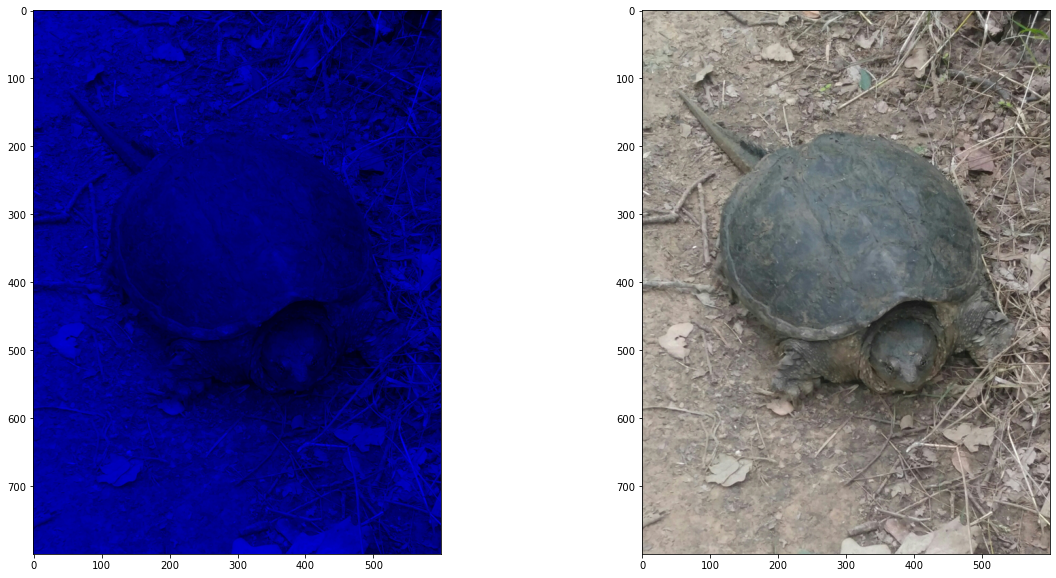

In [7]:
#Visualizing the impact of single channel
img=mpimg.imread(train_df.iloc[20,0])
img_b = togpu_blue(img)
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
axs[0].imshow(img_b/255)
axs[1].imshow(img)

### Only Red
This section fits a model exploiting only the red channel.

In [19]:
#Constructing training and validation generators for red 
train_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu_red, 
                                 rotation_range=90, brightness_range=[0.1, 2], shear_range=90, zoom_range=[1, 2])

val_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu_red)

batch_s = 20


train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='rgb',
    target_size=(350,350),
    batch_size=batch_s
)

validation_generator=val_datagen.flow_from_dataframe(
   valid_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='rgb',
    target_size=(350,350),
    batch_size=batch_s,
    shuffle=False
)

Found 11967 validated image filenames belonging to 12 classes.
Found 2557 validated image filenames belonging to 12 classes.


In [20]:
#Transfer learning
base_model = ResNet50(weights='imagenet',input_shape=(350, 350, 3),include_top=False)  # original input shape for model (480,480,3)
base_model.trainable = True #freeze parameters of imported model

inputs = keras.Input(shape=(350, 350, 3))
x = base_model(inputs, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu',name='last_conv')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(12, activation='softmax')(x) #predict the class
model = keras.Model(inputs, outputs) #put everything together
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 last_conv (Conv2D)          (None, 9, 9, 64)          1179712   
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 12)                780       
                                                                 
Total params: 24,768,204
Trainable params: 24,715,084
Non-trainable params: 53,120
__________________________________________

In [21]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']) 

In [22]:
csv_logger=CSVLogger('model_logs/training_red.log',separator=",",append=False)

In [23]:
stepepoch = 11967/20
valsteps = 2557/20
history = model.fit(train_generator,
      epochs=10,
      steps_per_epoch = stepepoch,
      validation_data=validation_generator,
      validation_steps = valsteps,
      callbacks=[earlystop, csv_logger])

Epoch 1/10
598/598 [==============================] - 1205s 2s/step - loss: 2.4669 - accuracy: 0.1417 - val_loss: 2.2776 - val_accuracy: 0.2002
Epoch 2/10
598/598 [==============================] - 1181s 2s/step - loss: 2.2658 - accuracy: 0.2002 - val_loss: 2.1289 - val_accuracy: 0.2640
Epoch 3/10
598/598 [==============================] - 1182s 2s/step - loss: 2.1733 - accuracy: 0.2372 - val_loss: 2.0946 - val_accuracy: 0.2632
Epoch 4/10
598/598 [==============================] - 1183s 2s/step - loss: 2.1126 - accuracy: 0.2636 - val_loss: 2.0409 - val_accuracy: 0.3000
Epoch 5/10
598/598 [==============================] - 1181s 2s/step - loss: 2.0704 - accuracy: 0.2853 - val_loss: 1.9812 - val_accuracy: 0.3207
Epoch 6/10
598/598 [==============================] - 1184s 2s/step - loss: 2.0222 - accuracy: 0.3009 - val_loss: 1.8934 - val_accuracy: 0.3496
Epoch 7/10
598/598 [==============================] - 1181s 2s/step - loss: 1.9909 - accuracy: 0.3105 - val_loss: 1.9480 - val_accuracy:

In [24]:
#Storing the predicted labels
prediction_classes = np.array([])
true_classes =  np.array([])
step = 0
for x, y in tqdm(validation_generator):
    prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x, verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
    step+=1
    if step == 128:
        break

 99%|█████████▉| 127/128 [01:34<00:00,  1.35it/s]


In [28]:
valid_df['predicted_label_red']=prediction_classes
valid_df.to_csv('color_analysis_results.csv', index=False)

In [29]:
print(classification_report(true_classes, prediction_classes, zero_division=True))

              precision    recall  f1-score   support

         0.0       0.21      0.26      0.23       192
         1.0       0.29      0.43      0.34       199
         2.0       0.35      0.33      0.34       199
         3.0       0.37      0.27      0.31       205
         4.0       0.15      0.03      0.05       146
         5.0       0.65      0.38      0.48       194
         6.0       0.36      0.57      0.44       215
         7.0       0.56      0.76      0.64       238
         8.0       0.74      0.69      0.71       273
         9.0       0.42      0.39      0.41       228
        10.0       0.21      0.16      0.18       221
        11.0       0.28      0.30      0.29       247

    accuracy                           0.40      2557
   macro avg       0.38      0.38      0.37      2557
weighted avg       0.40      0.40      0.39      2557



In [31]:
#Save the model
model.save('saved_models/model_red')
model.save('saved_models/model_red.h5')

INFO:tensorflow:Assets written to: saved_models/model_red/assets


INFO:tensorflow:Assets written to: saved_models/model_red/assets


### Only Green
This section fits a model exploiting only the green channel.

In [10]:
#Creating generators
train_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu_green, 
                                 rotation_range=90, brightness_range=[0.1, 2], shear_range=90, zoom_range=[1, 2])

val_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu_green)

batch_s = 20


train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='rgb',
    target_size=(350,350),
    batch_size=batch_s
)

validation_generator=val_datagen.flow_from_dataframe(
   valid_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='rgb',
    target_size=(350,350),
    batch_size=batch_s,
    shuffle=False
)

Found 11967 validated image filenames belonging to 12 classes.
Found 2557 validated image filenames belonging to 12 classes.


In [14]:
#Transfer learning
base_model = ResNet50(weights='imagenet',input_shape=(350, 350, 3),include_top=False)  # original input shape for model (480,480,3)
base_model.trainable = True #freeze parameters of imported model

inputs = keras.Input(shape=(350, 350, 3))
x = base_model(inputs, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu',name='last_conv')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(12, activation='softmax')(x) #predict the class
model = keras.Model(inputs, outputs) #put everything together
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 last_conv (Conv2D)          (None, 9, 9, 64)          1179712   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
Total params: 24,768,204
Trainable params: 24,715,084
Non-trainable params: 53,120
____________________________________________

In [15]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']) 

In [18]:
earlystop=EarlyStopping(monitor='val_accuracy',
                        min_delta=0.01,
                        patience=3,
                        verbose=1,
                        mode='auto')
csv_logger=CSVLogger('training_green.log',separator=",",append=False)

In [19]:
stepepoch = 11967 /20
valsteps = 2557/20
history = model.fit(train_generator,
      epochs=10,
      steps_per_epoch = stepepoch,
      validation_data=validation_generator,
      validation_steps = valsteps,
      callbacks=[earlystop, csv_logger])

Epoch 1/10
598/598 [==============================] - 1218s 2s/step - loss: 2.5239 - accuracy: 0.1367 - val_loss: 2.2633 - val_accuracy: 0.2049
Epoch 2/10
598/598 [==============================] - 1188s 2s/step - loss: 2.2153 - accuracy: 0.2224 - val_loss: 2.1173 - val_accuracy: 0.2620
Epoch 3/10
598/598 [==============================] - 1187s 2s/step - loss: 2.1115 - accuracy: 0.2637 - val_loss: 2.0577 - val_accuracy: 0.2804
Epoch 4/10
598/598 [==============================] - 1184s 2s/step - loss: 2.0462 - accuracy: 0.2814 - val_loss: 1.9922 - val_accuracy: 0.2992
Epoch 5/10
598/598 [==============================] - 1189s 2s/step - loss: 2.0148 - accuracy: 0.3027 - val_loss: 1.9989 - val_accuracy: 0.3117
Epoch 6/10
598/598 [==============================] - 1188s 2s/step - loss: 1.9765 - accuracy: 0.3173 - val_loss: 1.9331 - val_accuracy: 0.3262
Epoch 7/10
598/598 [==============================] - 1192s 2s/step - loss: 1.9508 - accuracy: 0.3267 - val_loss: 1.8874 - val_accuracy:

In [20]:
#storing the predictions
prediction_classes = np.array([])
true_classes =  np.array([])
step = 0
for x, y in tqdm(validation_generator):
    prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x, verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
    step+=1
    if step == 128:
        break

 99%|█████████▉| 127/128 [01:34<00:00,  1.35it/s]


In [21]:
valid_df['predicted_label_green']=prediction_classes
valid_df.to_csv('green_analysis_results.csv', index=False)

In [22]:
print(classification_report(true_classes, prediction_classes, zero_division=True))

              precision    recall  f1-score   support

         0.0       0.27      0.24      0.26       192
         1.0       0.29      0.51      0.37       199
         2.0       0.31      0.46      0.37       199
         3.0       0.30      0.30      0.30       205
         4.0       0.28      0.24      0.26       146
         5.0       0.33      0.58      0.42       194
         6.0       0.49      0.48      0.48       215
         7.0       0.57      0.69      0.63       238
         8.0       0.78      0.63      0.70       273
         9.0       0.50      0.27      0.35       228
        10.0       0.29      0.10      0.15       221
        11.0       0.36      0.19      0.25       247

    accuracy                           0.40      2557
   macro avg       0.40      0.39      0.38      2557
weighted avg       0.41      0.40      0.39      2557



In [23]:
#Save the model
model.save('saved_models/model_green')
model.save('saved_models/model_green.h5')

INFO:tensorflow:Assets written to: saved_models/model_green/assets


INFO:tensorflow:Assets written to: saved_models/model_green/assets


### Only Blue
This section fits a model exploiting only the blue channel.

In [6]:
#creating generators
train_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu_blue, 
                                 rotation_range=90, brightness_range=[0.1, 2], shear_range=90, zoom_range=[1, 2])

val_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu_blue)

batch_s = 20


train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='rgb',
    target_size=(350,350),
    batch_size=batch_s
)

validation_generator=val_datagen.flow_from_dataframe(
   valid_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    color_mode='rgb',
    target_size=(350,350),
    batch_size=batch_s,
    shuffle=False
)

Found 11967 validated image filenames belonging to 12 classes.
Found 2557 validated image filenames belonging to 12 classes.


In [7]:
#Transfer learning
base_model = ResNet50(weights='imagenet',input_shape=(350, 350, 3),include_top=False)  # original input shape for model (480,480,3)
base_model.trainable = True #freeze parameters of imported model

inputs = keras.Input(shape=(350, 350, 3))
x = base_model(inputs, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu',name='last_conv')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(12, activation='softmax')(x) #predict the class
model = keras.Model(inputs, outputs) #put everything together
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 last_conv (Conv2D)          (None, 9, 9, 64)          1179712   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
Total params: 24,768,204
Trainable params: 24,715,084
Non-trainable params: 53,120
____________________________________________

In [8]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']) 

In [11]:
earlystop=EarlyStopping(monitor='val_accuracy',
                        min_delta=0.01,
                        patience=3,
                        verbose=1,
                        mode='auto')
csv_logger=CSVLogger('training_blue.log',separator=",",append=False)

In [12]:
stepepoch = 11967/20
valsteps = 2557/20
history = model.fit(train_generator,
      epochs=10,
      steps_per_epoch = stepepoch,
      validation_data=validation_generator,
      validation_steps = valsteps,
      callbacks=[earlystop, csv_logger])

Epoch 1/10
598/598 [==============================] - 1212s 2s/step - loss: 2.4571 - accuracy: 0.1574 - val_loss: 2.2785 - val_accuracy: 0.2206
Epoch 2/10
598/598 [==============================] - 1183s 2s/step - loss: 2.2521 - accuracy: 0.2076 - val_loss: 2.0983 - val_accuracy: 0.2624
Epoch 3/10
598/598 [==============================] - 1181s 2s/step - loss: 2.1384 - accuracy: 0.2488 - val_loss: 2.0478 - val_accuracy: 0.2734
Epoch 4/10
598/598 [==============================] - 1181s 2s/step - loss: 2.0913 - accuracy: 0.2761 - val_loss: 2.0309 - val_accuracy: 0.2851
Epoch 5/10
598/598 [==============================] - 1180s 2s/step - loss: 2.0551 - accuracy: 0.2803 - val_loss: 1.9814 - val_accuracy: 0.2972
Epoch 6/10
598/598 [==============================] - 1183s 2s/step - loss: 2.0386 - accuracy: 0.2905 - val_loss: 1.9853 - val_accuracy: 0.3133
Epoch 7/10
598/598 [==============================] - 1181s 2s/step - loss: 2.0150 - accuracy: 0.2977 - val_loss: 1.9517 - val_accuracy:

In [13]:
#Storing the predictions
prediction_classes = np.array([])
true_classes =  np.array([])
step = 0
for x, y in tqdm(validation_generator):
    prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x, verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
    step+=1
    if step == 128:
        break

 99%|█████████▉| 127/128 [01:34<00:00,  1.34it/s]


In [14]:
valid_df['predicted_label_blue']=prediction_classes
valid_df.to_csv('blue_analysis_results.csv', index=False)

In [15]:
print(classification_report(true_classes, prediction_classes, zero_division=True))

              precision    recall  f1-score   support

         0.0       0.17      0.09      0.12       192
         1.0       0.28      0.59      0.38       199
         2.0       0.36      0.12      0.18       199
         3.0       0.27      0.23      0.25       205
         4.0       0.23      0.05      0.09       146
         5.0       0.31      0.29      0.30       194
         6.0       0.36      0.30      0.33       215
         7.0       0.38      0.72      0.50       238
         8.0       0.71      0.71      0.71       273
         9.0       0.38      0.40      0.39       228
        10.0       0.25      0.11      0.15       221
        11.0       0.26      0.35      0.30       247

    accuracy                           0.35      2557
   macro avg       0.33      0.33      0.31      2557
weighted avg       0.34      0.35      0.33      2557



In [16]:
#Save the model
model.save('saved_models/model_blue')
model.save('saved_models/model_blue.h5')

INFO:tensorflow:Assets written to: saved_models/model_blue/assets


INFO:tensorflow:Assets written to: saved_models/model_blue/assets
